In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_curve, accuracy_score,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
df = pd.read_csv("carclaims.csv")

In [3]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [4]:
print("Number of Features Available:",df.shape[1])
print("Number of Samples Available :",df.shape[0])

Number of Features Available: 33
Number of Samples Available : 15420


In [5]:
df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days:Policy-Accident    0
Days:Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
FraudFound              0
dtype: int64

# EDA (Exploratory Data Analysis)

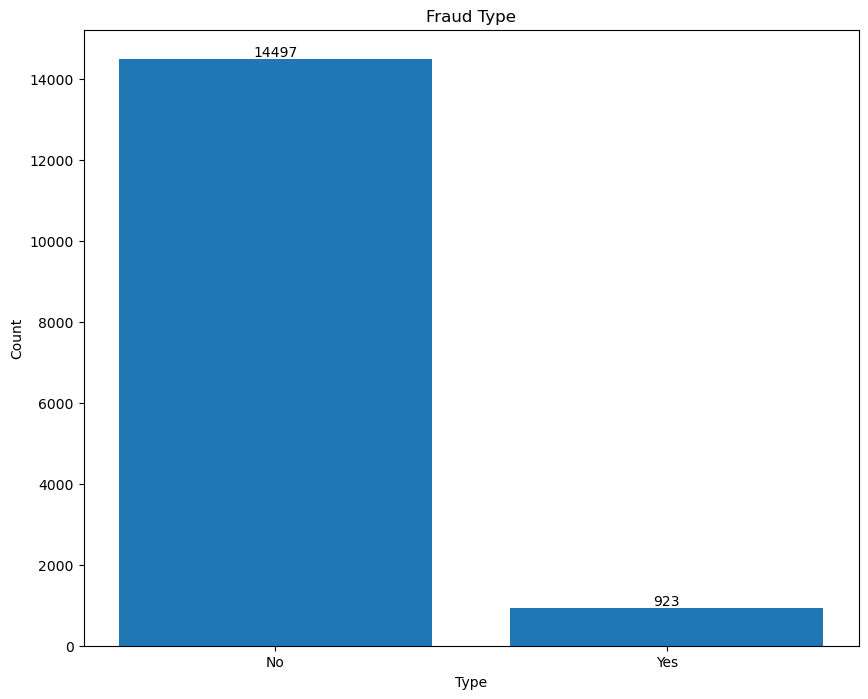

In [6]:

plt.figure(figsize=(10,8))
bars = plt.bar(df.FraudFound.value_counts().index, df.FraudFound.value_counts().values)
plt.title("Fraud Type")
plt.xlabel("Type")
plt.ylabel("Count")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')


plt.show()


The number of frauds found is only 6%, it is clear that the dataset is imbalanced.

In [7]:
# Replacing the variables with 0 and 1

df.loc[df['FraudFound'] == 'No','FraudFound'] = 0
df.loc[df['FraudFound'] == 'Yes','FraudFound'] = 1

df['FraudFound'] = df['FraudFound'].astype(int)

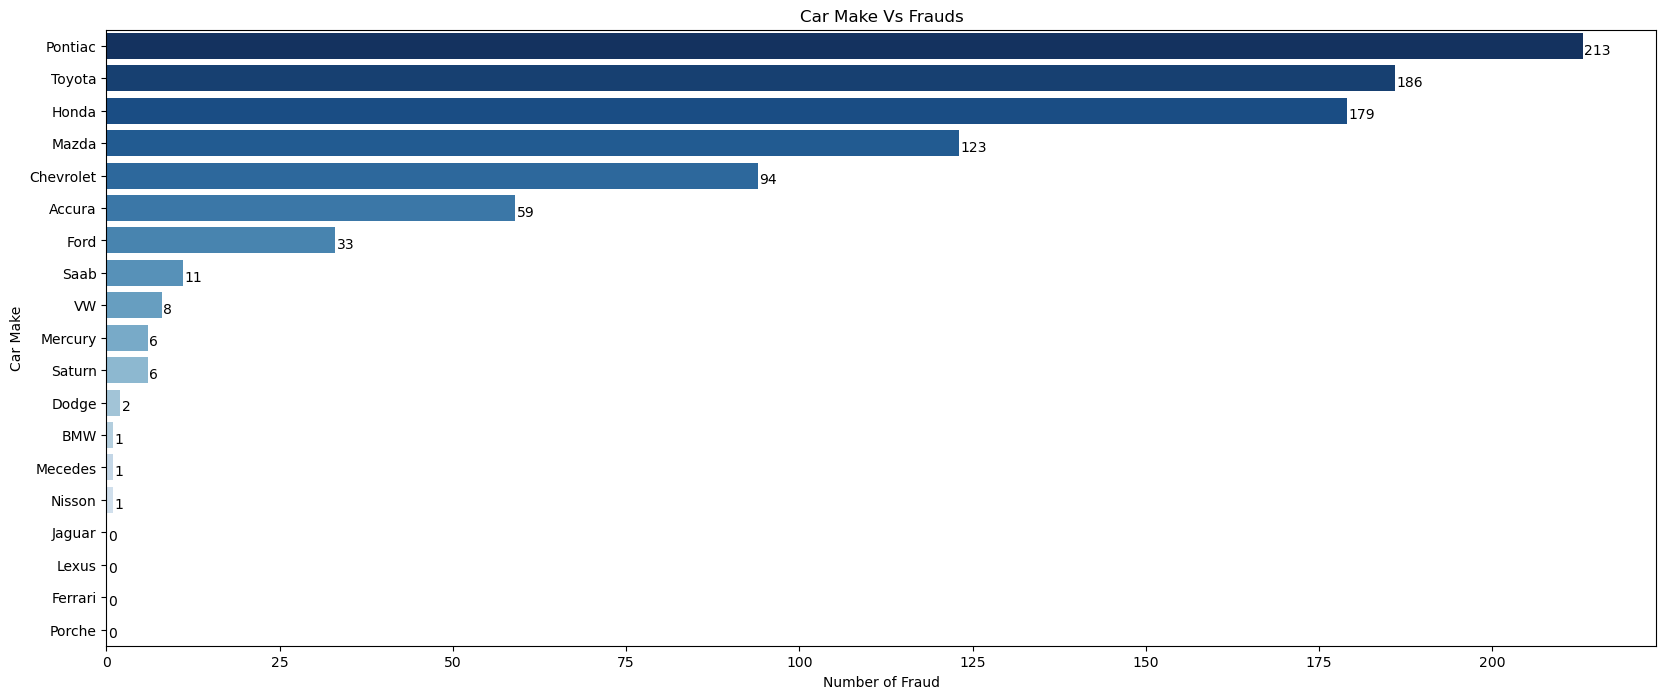

In [8]:
#Plotting the graph separately showing frauds found in each Car Makers

make = df.groupby('Make')['FraudFound'].sum().sort_values(ascending=False)
plt.figure(figsize=(20,8))
plt.title("Car Make Vs Frauds")


cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0, 1, len(make.index))]

ax = sns.barplot(y=make.index, x=make.values, orient='h', palette=colors[::-1])
for i, v in enumerate(make.values):
    ax.text(v + 0.2, i + .25, str(format(int(v), ',d')), color='black', fontweight='light')

plt.xlabel("Number of Fraud")
plt.ylabel("Car Make")
plt.show()


Most of the Frauds found in Pontiac, Toyota, Honda and none in Ferrari, Jaguar, Lexus and Porche.

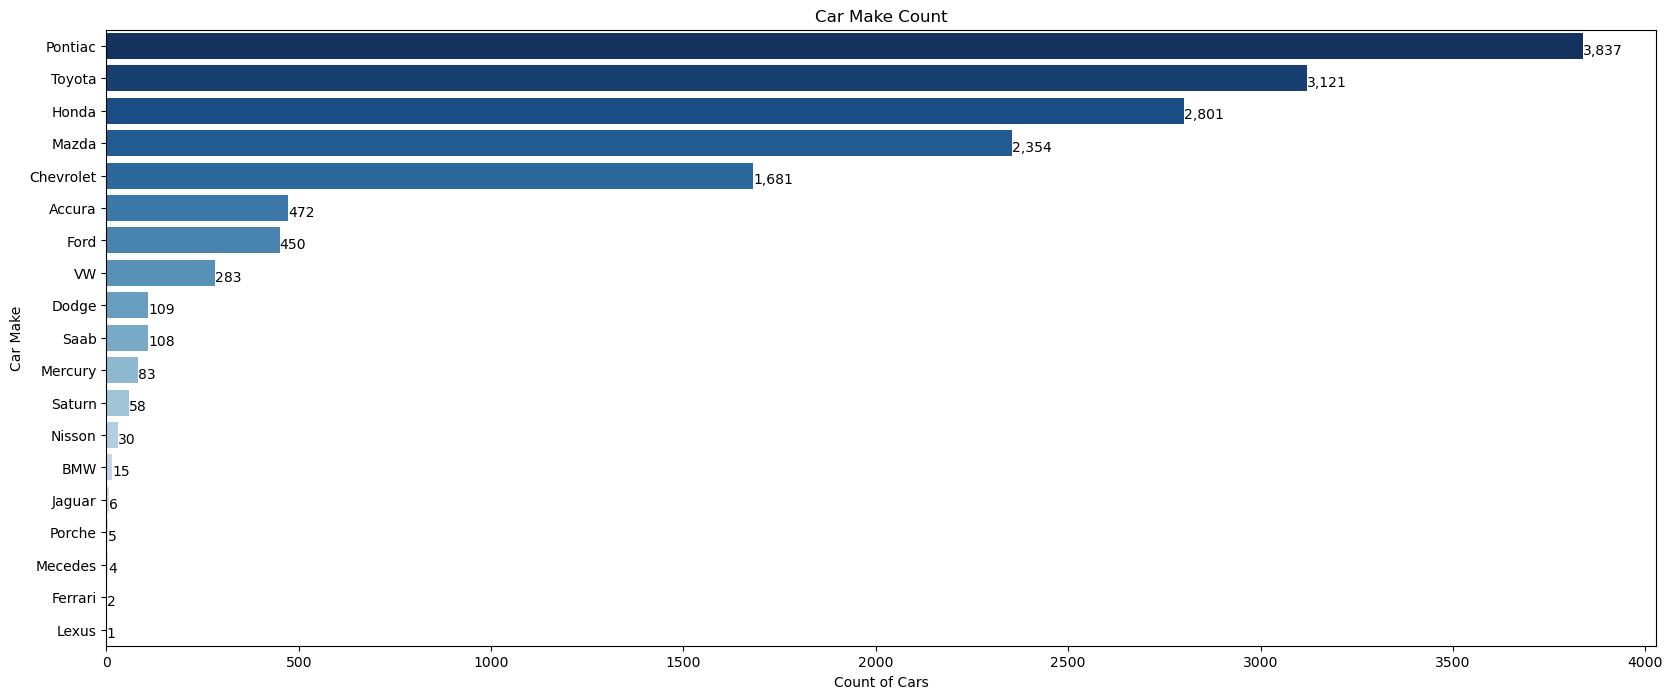

In [9]:
# Plotting the number of claims found in each Car Makers.

make_count = df['Make'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(20,8))
plt.title("Car Make Count")


cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0, 1, len(make_count.index))]

ax = sns.barplot(y=make_count.index, x=make_count.values, orient='h', palette=colors[::-1])
for i, v in enumerate(make_count.values):
    ax.text(v + 0.2, i + .25, str(format(int(v), ',d')), color='black', fontweight='light')

plt.ylabel("Car Make")
plt.xlabel("Count of Cars")
plt.show()


The number of claims made by Jaguar, Porche, Ferrari, Lexus is very low that might be the reason the fraud found in these carmakers is None.

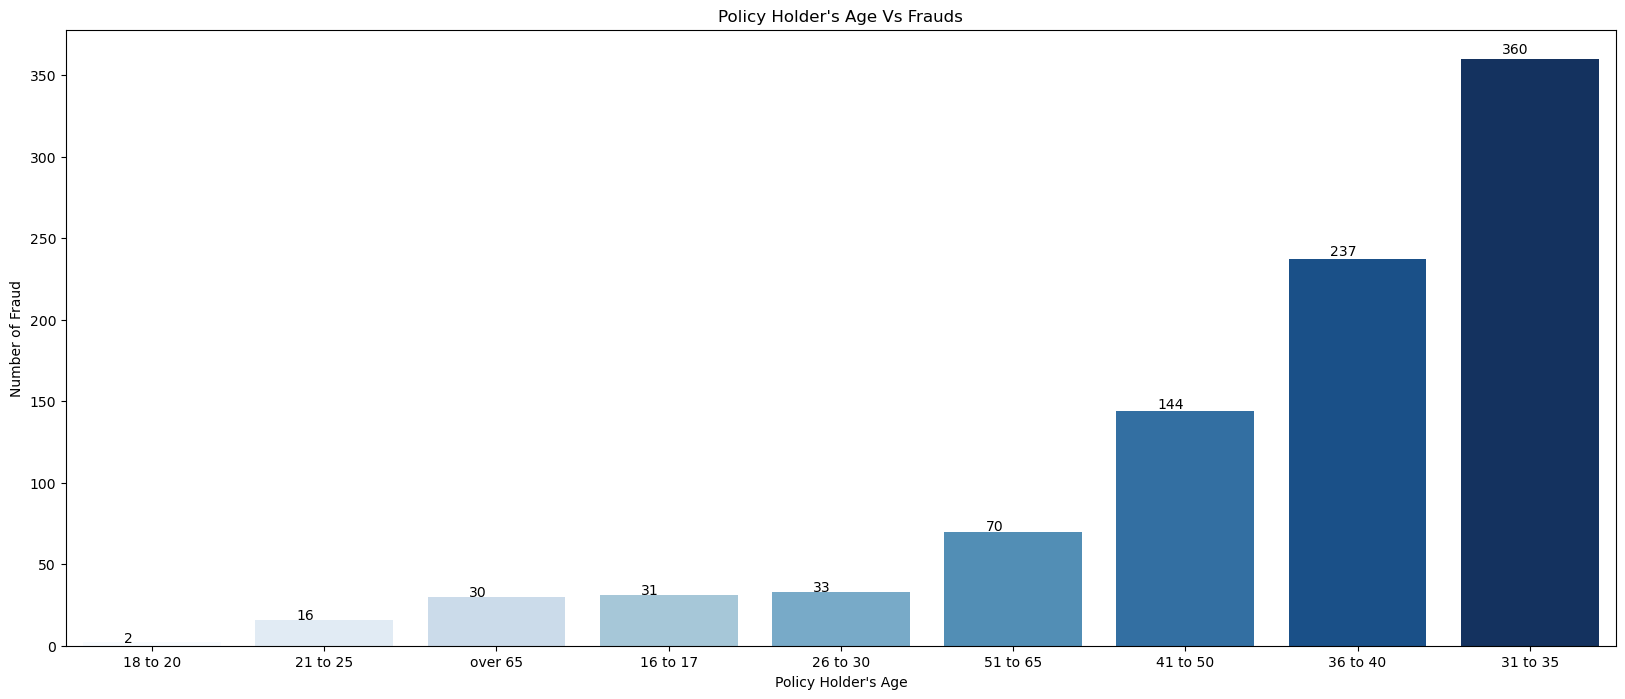

In [10]:
# Plotting the number of frauds found in each Policy Holder's Age

policyAge = df.groupby('AgeOfPolicyHolder')['FraudFound'].sum().sort_values(ascending=True)
plt.figure(figsize=(20,8))
plt.title("Policy Holder's Age Vs Frauds")


cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0, 1, len(policyAge.index))]

ax = sns.barplot(x=policyAge.index, y=policyAge.values, palette=colors)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))

plt.xlabel("Policy Holder's Age")
plt.ylabel("Number of Fraud")
plt.show()


Most of the Frauds seen are from age 31-35.

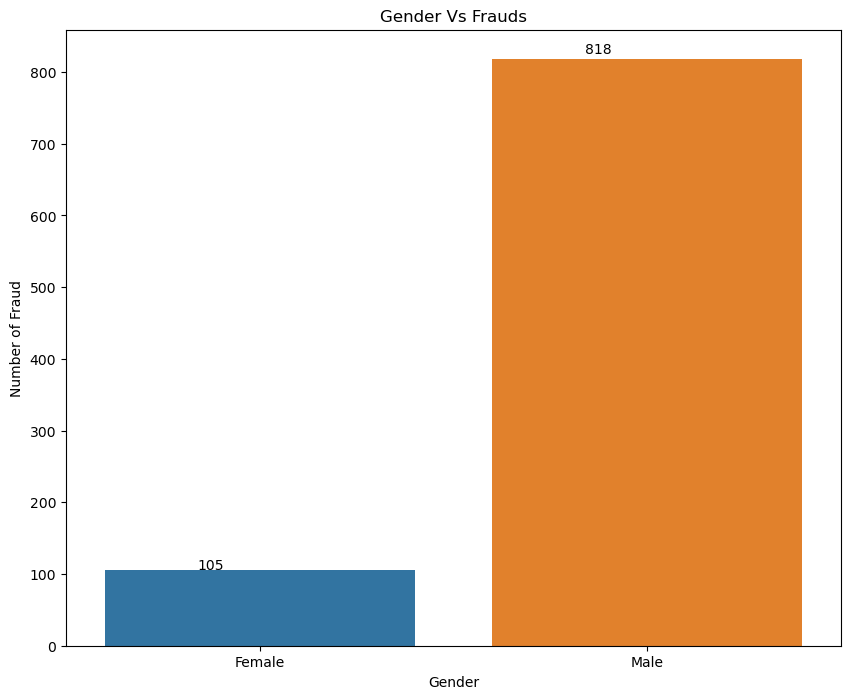

In [11]:
#Plotting the graph separately showing frauds found in each gender

gender = df.groupby('Sex')['FraudFound'].sum()
plt.figure(figsize=(10,8))
plt.title("Gender Vs Frauds")

ax = sns.barplot(x=gender.index, y=gender.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))

plt.xlabel("Gender")
plt.ylabel("Number of Fraud")
plt.show()


Most of the frauds found are claimed by Males which is 89%.

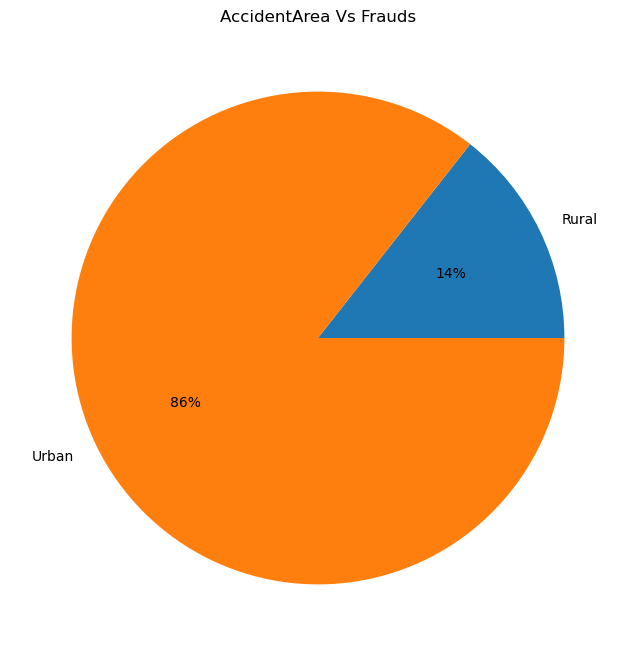

In [12]:
#Plotting the graph separately showing frauds found in each Area

accidentArea = df.groupby('AccidentArea')['FraudFound'].sum()

plt.figure(figsize=(10,8))
plt.title("AccidentArea Vs Frauds")

plt.pie(accidentArea.values,labels=accidentArea.index,  autopct='%.0f%%')

plt.show()

More number of frauds are found in Urban areas when compared to Rural areas.

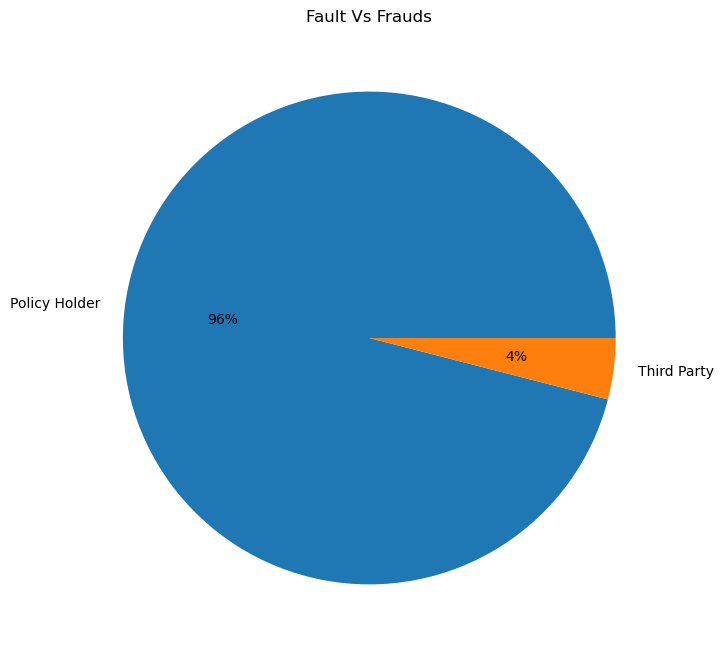

In [13]:
#Plotting the pie chart separately showing frauds found in Type of Faults
fault = df.groupby('Fault')['FraudFound'].sum()

plt.figure(figsize=(10,8))
plt.title("Fault Vs Frauds")
plt.pie(fault.values,labels=fault.index,  autopct='%.0f%%')
plt.show()

From this chart we can say that frauds are done more by Policy Holders than by third Party.

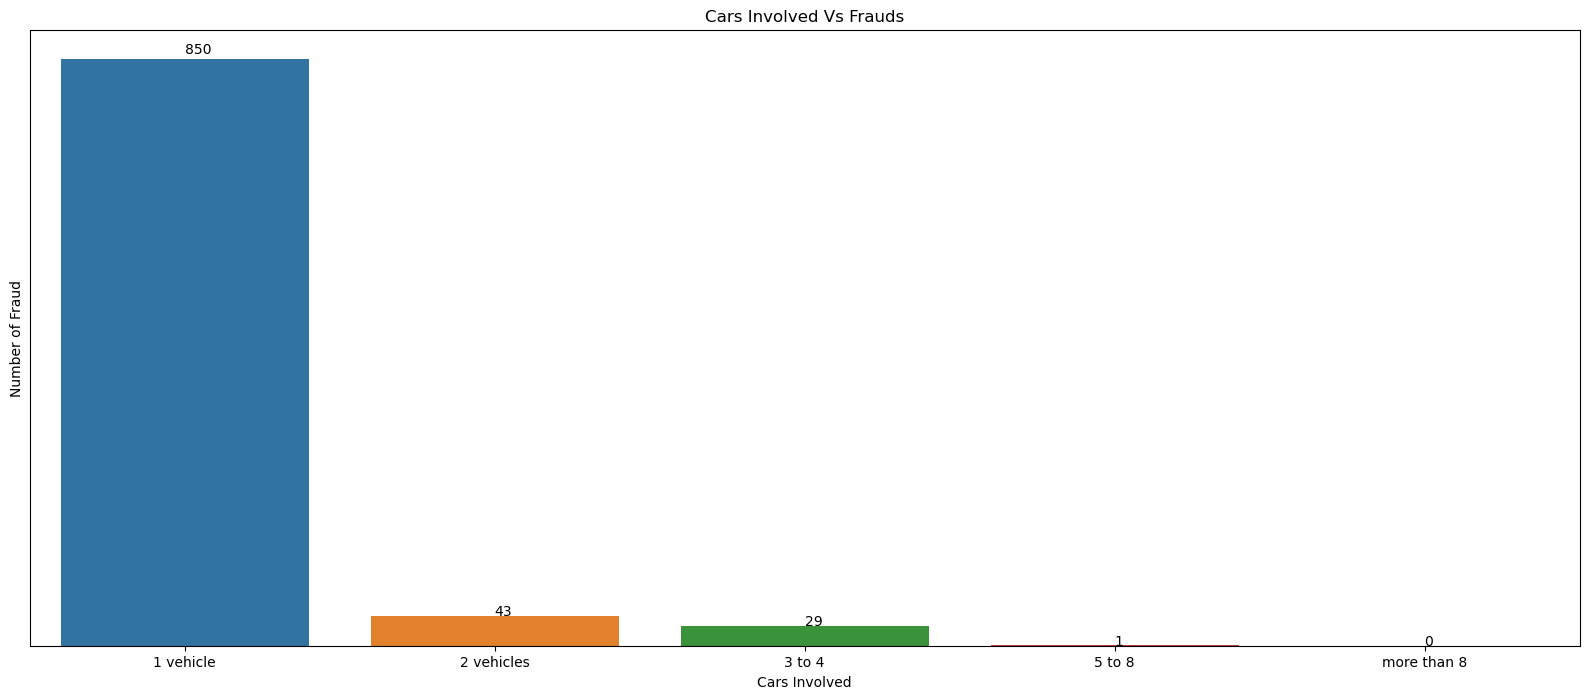

In [14]:
#Plotting the graph separately showing frauds found in NumberofCars involved
cars = df.groupby('NumberOfCars')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Cars Involved Vs Frauds")

ax = sns.barplot(x=cars.index,y=cars.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.4, p.get_height()*1.01))
plt.xlabel("Cars Involved")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

We can see clearly that fraud found is very high when the accident involved only one vehicle.

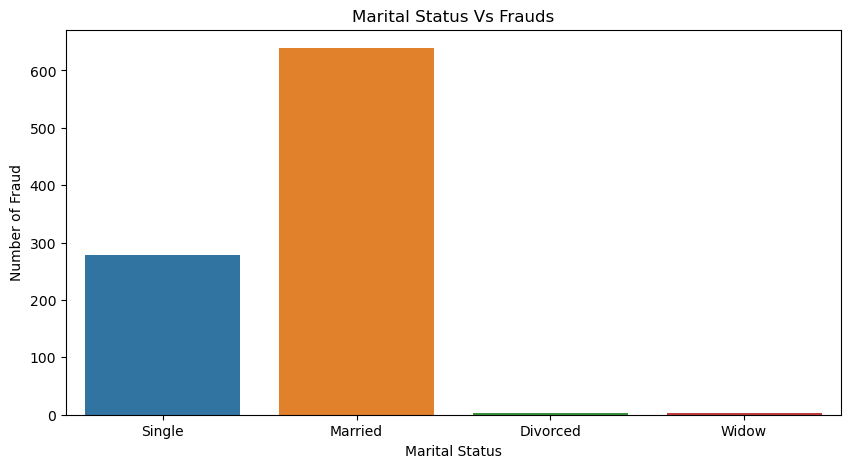

In [15]:
#Plotting the graph separately showing frauds found in MaritalStatus
fraud = df[df['FraudFound'] == 1]
plt.figure(figsize=(10,5))
plt.title("Marital Status Vs Frauds")
sns.countplot(x=fraud['MaritalStatus']);
plt.xlabel("Marital Status")
plt.ylabel("Number of Fraud");

More number of frauds are found in the Married category.

In [16]:
le = LabelEncoder()

cols = df.select_dtypes('O').columns

df[cols]= df[cols].apply(le.fit_transform)
df['Year'] = le.fit_transform(df.Year)

<Axes: >

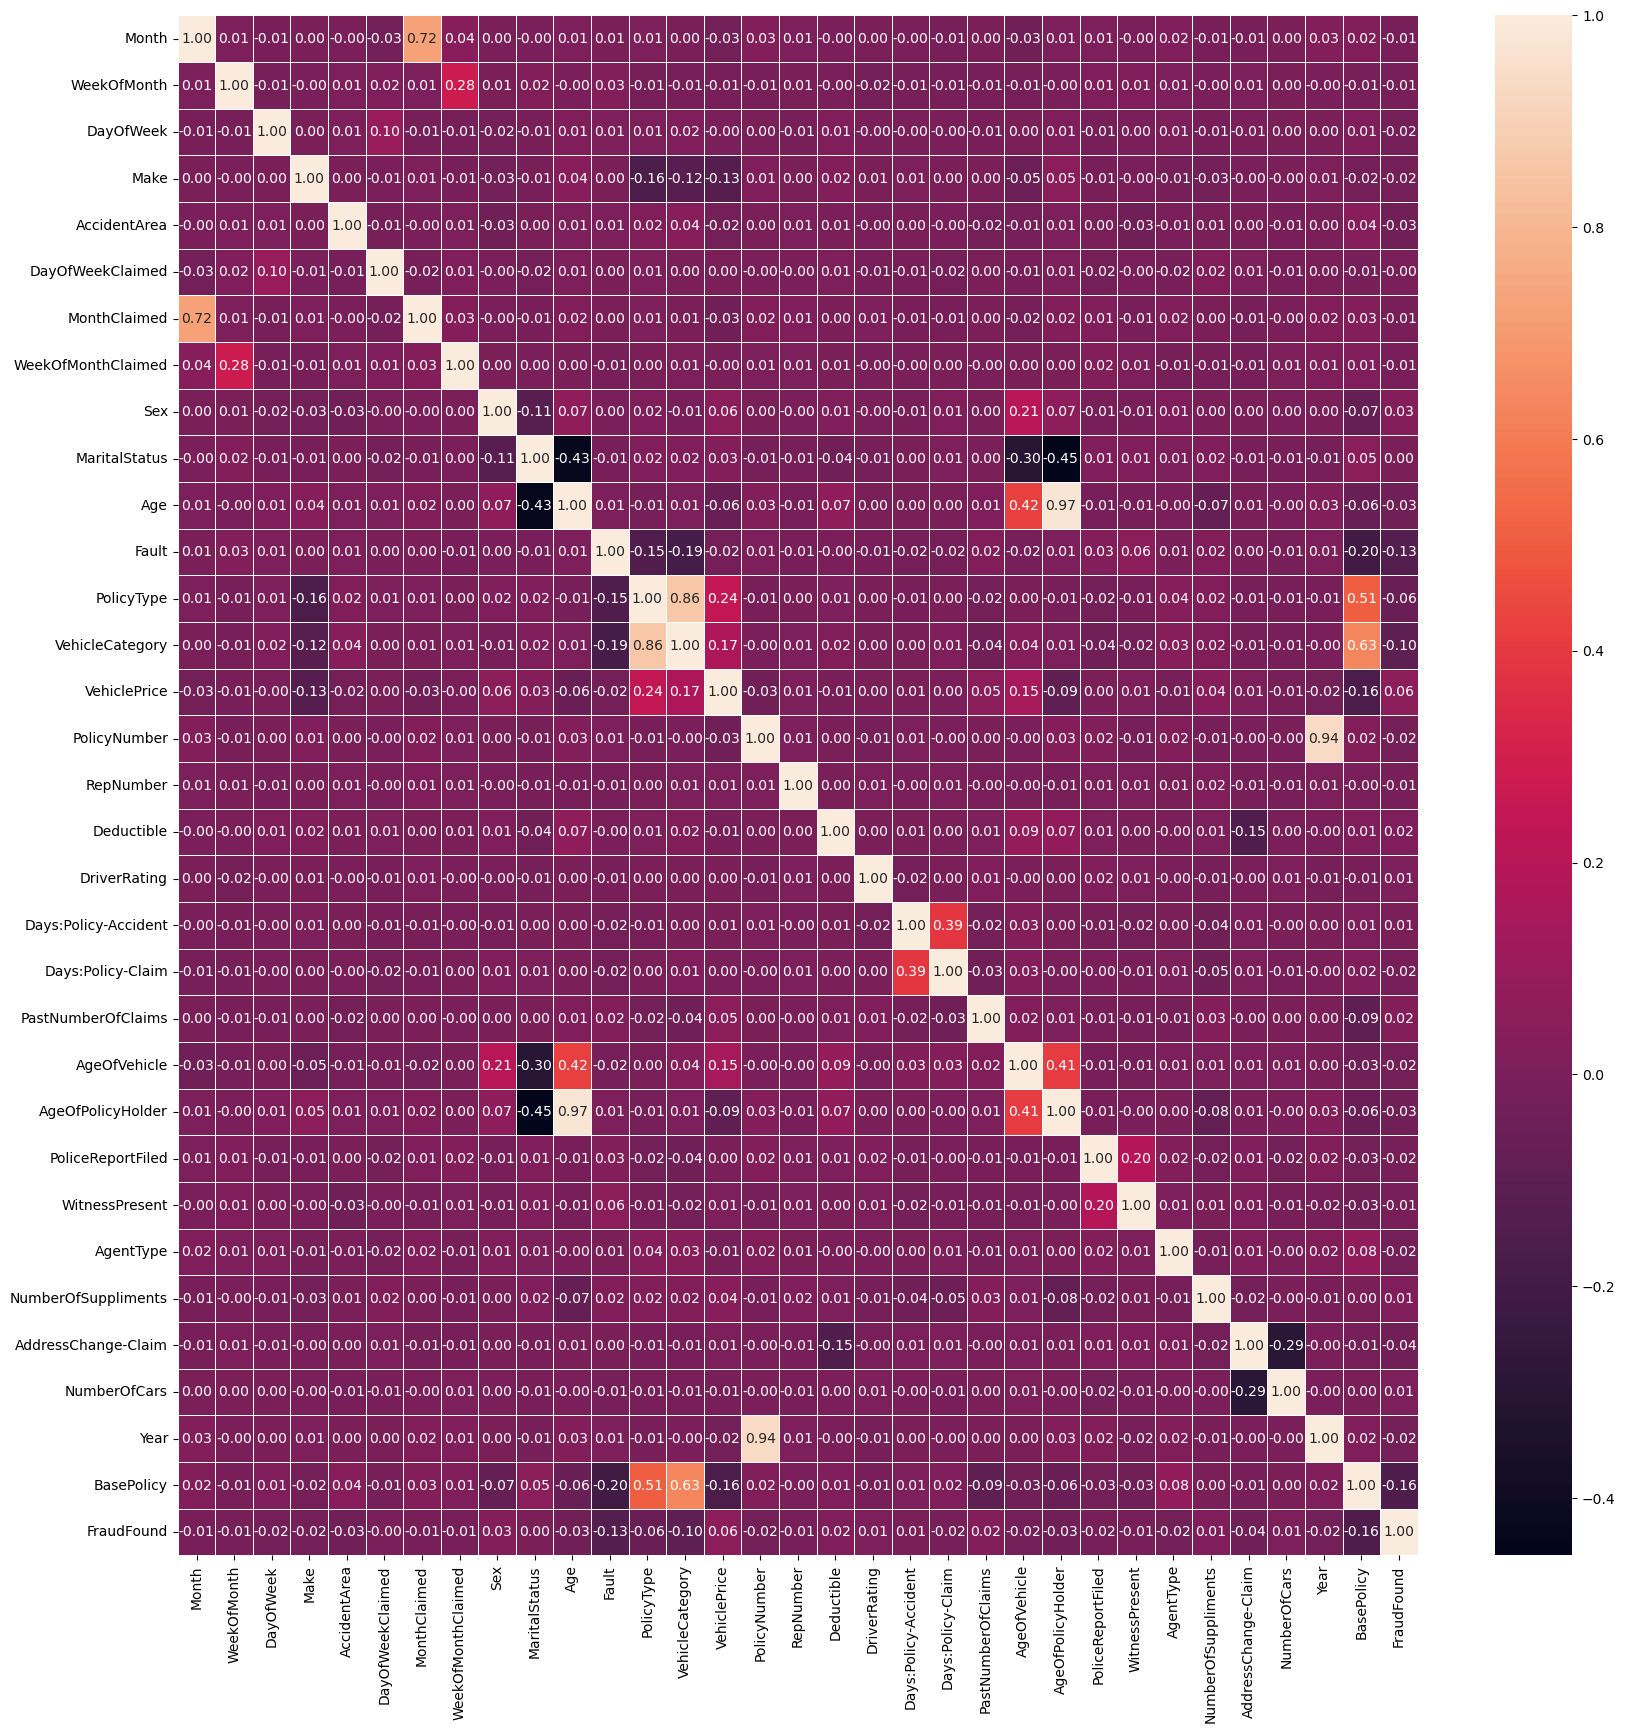

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,linewidth=0.5,fmt="0.2f")

In [18]:
df_new = df[['Make', 'AccidentArea','Sex',
       'MaritalStatus','Fault', 'VehicleCategory',\
       'VehiclePrice', 'Year',\
       'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim',\
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',\
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',\
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars',\
       'BasePolicy', 'FraudFound']]

<Axes: >

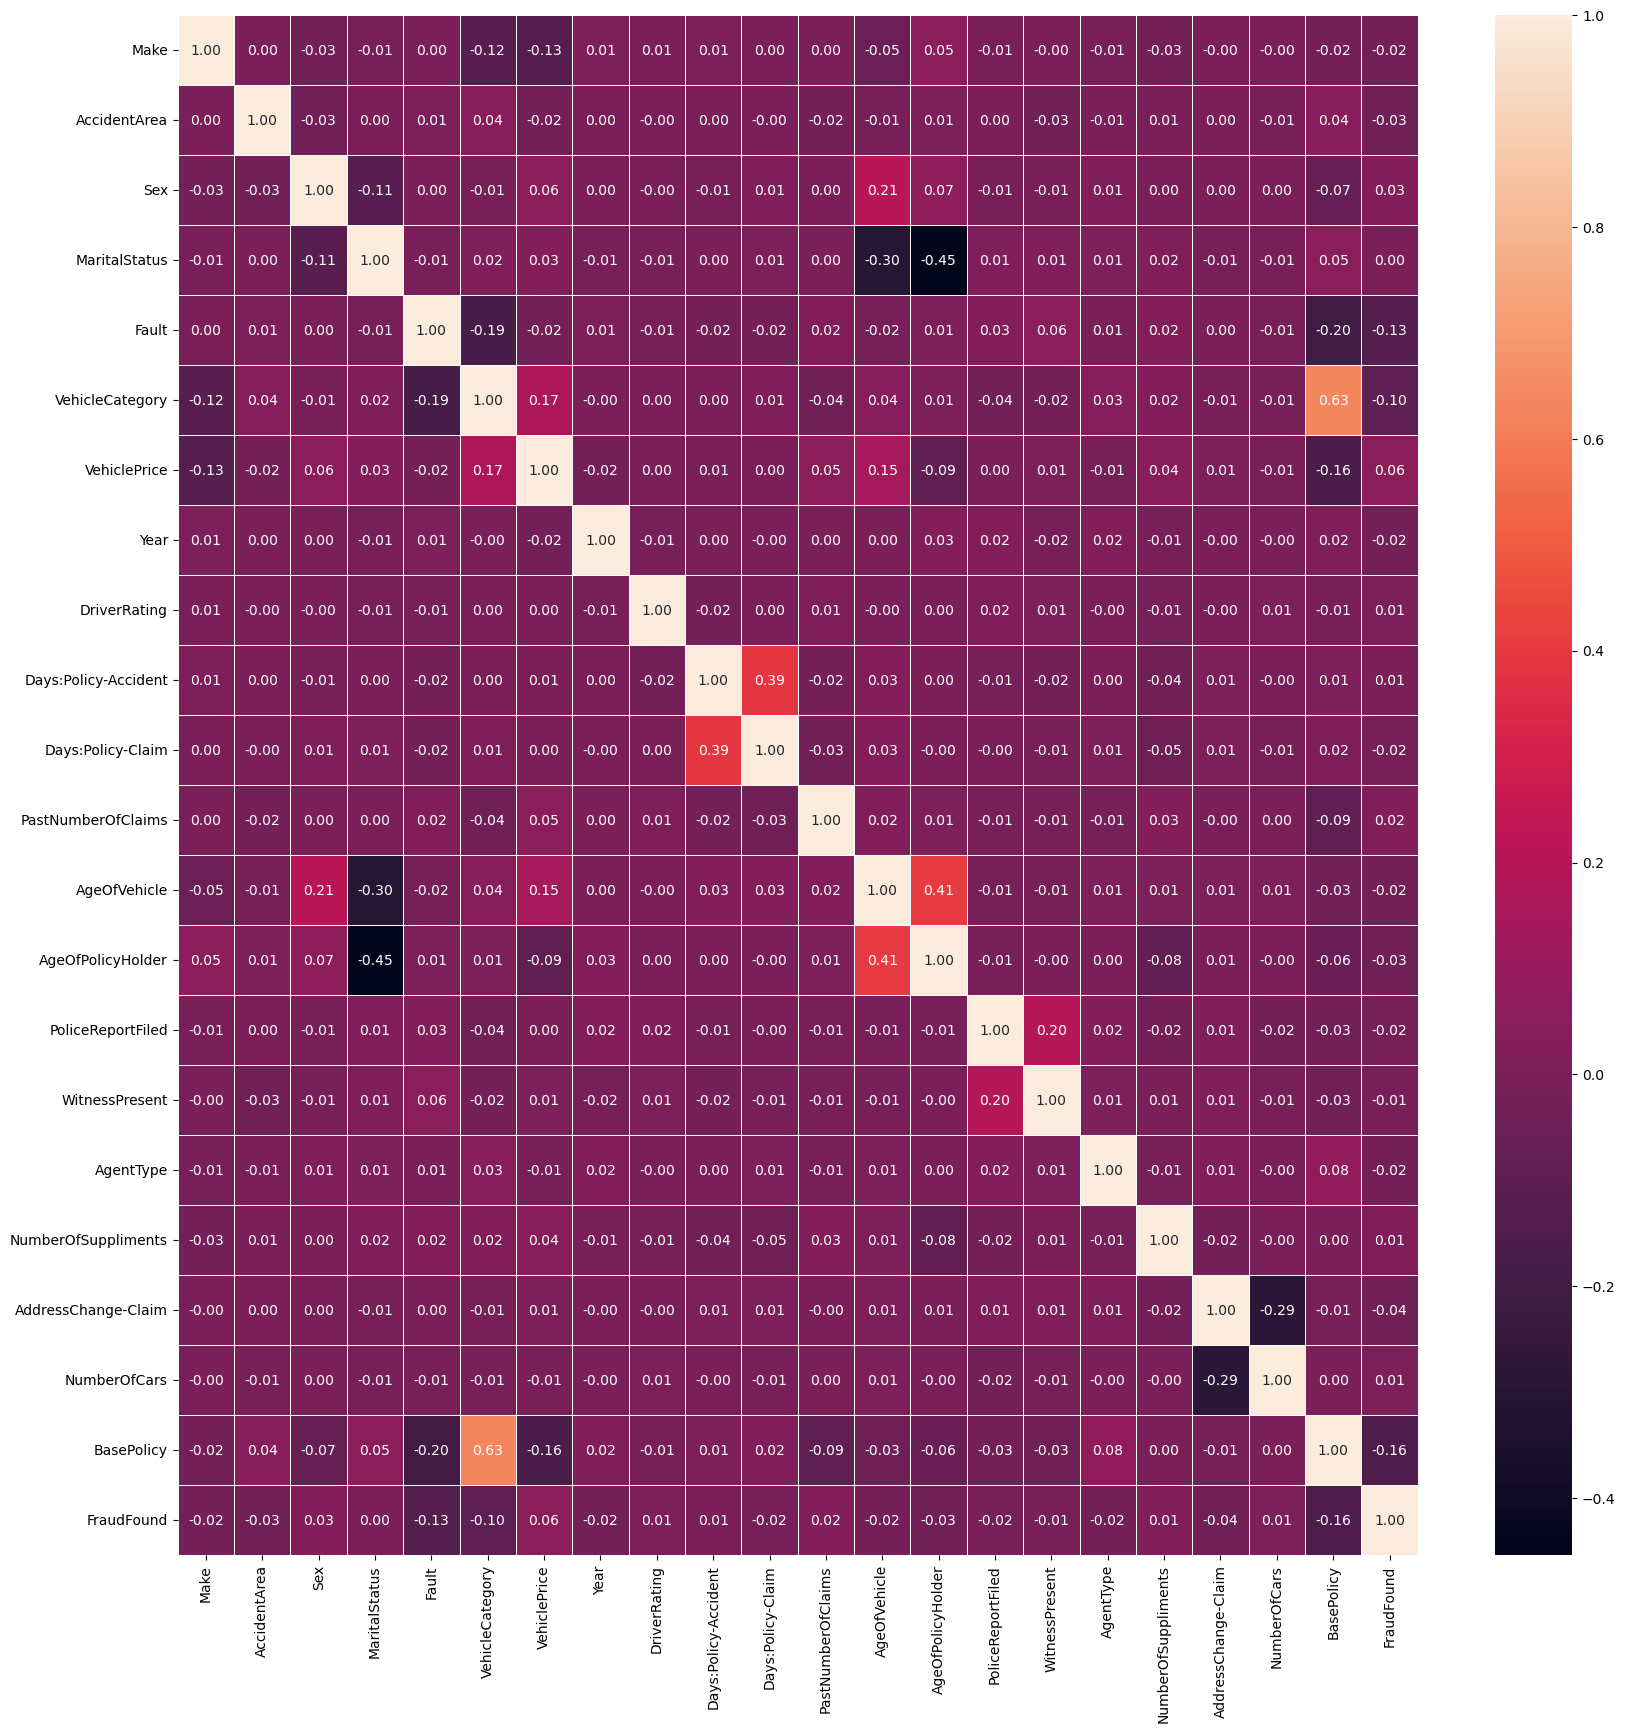

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(df_new.corr(),annot=True,linewidth=0.5,fmt="0.2f")

# Split Data

In [20]:
X = df_new.drop(['FraudFound'], axis=1)
y = df_new['FraudFound']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10794, 21), (4626, 21), (10794,), (4626,))

In [21]:
def conf_matrix(y_test,y_pred):
    con_matrix = confusion_matrix(y_test,y_pred)
    con_matrix = pd.DataFrame(con_matrix,range(2),range(2))
    
    plt.figure(figsize=(5,5))
    plt.title("Confusion Matrix")
    sns.heatmap(con_matrix,annot=True,cbar=False,fmt='g')

# Model Development

Accuracy of LogisticRegression model: 0.9399048854301773
F1 Score for LogisticRegression model: 0.0
Precision for LogisticRegression model: 0.0
Recall for LogisticRegression model: 0.0
ROC AUC for LogisticRegression: 0.49988503104161874


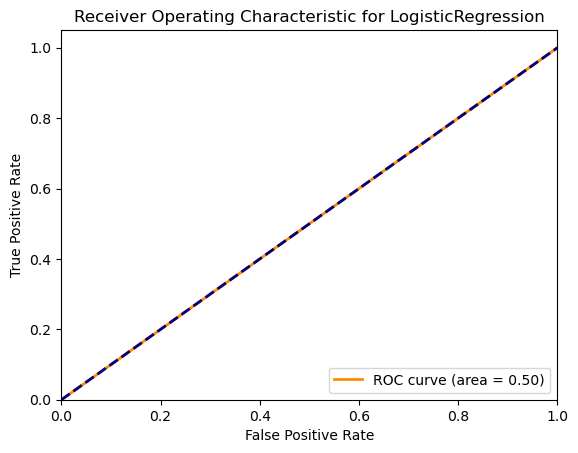

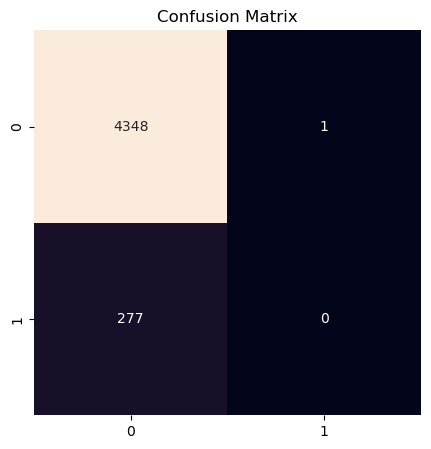

In [22]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)


print('Accuracy of LogisticRegression model:',accuracy_score(y_test, lr_pred))
print('F1 Score for LogisticRegression model:', f1_score(y_test, lr_pred))
print('Precision for LogisticRegression model:', precision_score(y_test, lr_pred))
print('Recall for LogisticRegression model:', recall_score(y_test, lr_pred))


fpr, tpr, thresholds = roc_curve(y_test, lr_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for LogisticRegression:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for LogisticRegression')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test,lr_pred)

The Logistic Regression model has an accuracy of 94.01%. However, the F1 Score, Precision, and Recall are all 0.0, and the ROC AUC is 0.5.

This suggests that while the model is accurate in terms of correctly predicting the majority class, it’s not doing well in predicting the minority class. The F1 Score, Precision, and Recall are all measures of a model’s performance in terms of handling both classes in a balanced way. A score of 0.0 indicates that the model is not predicting the minority class correctly at all.

The ROC AUC score of 0.5 also suggests that the model’s ability to distinguish between the classes is no better than random chance.

Accuracy of RandomForestClassifier model: 0.9399048854301773
F1 Score for RandomForestClassifier model: 0.0915032679738562
Precision for RandomForestClassifier model: 0.4827586206896552
Recall for RandomForestClassifier model: 0.05054151624548736
ROC AUC for LogisticRegression: 0.5235462237470252


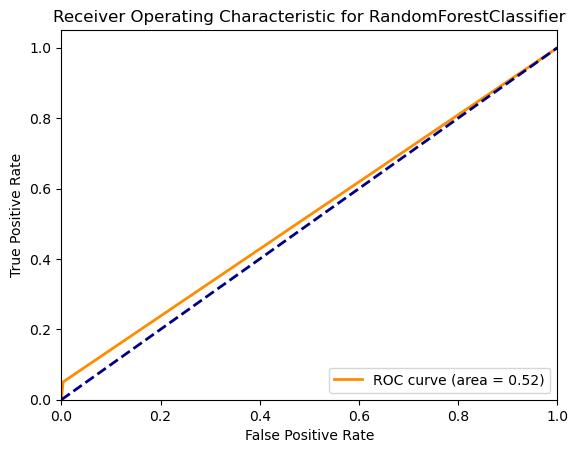

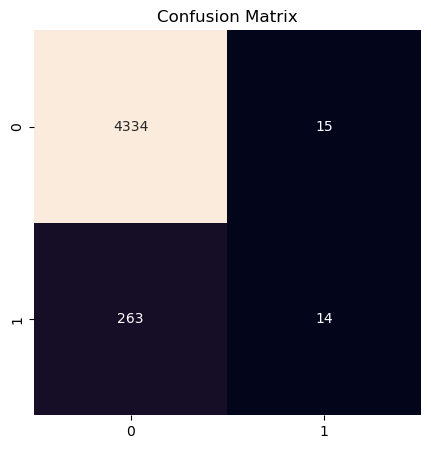

In [23]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

acc_rfc = accuracy_score(y_test, rfc_pred)
print('Accuracy of RandomForestClassifier model:',accuracy_score(y_test, rfc_pred))
print('F1 Score for RandomForestClassifier model:', f1_score(y_test, rfc_pred))
print('Precision for RandomForestClassifier model:', precision_score(y_test, rfc_pred))
print('Recall for RandomForestClassifier model:', recall_score(y_test, rfc_pred))


fpr, tpr, thresholds = roc_curve(y_test, rfc_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for LogisticRegression:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test,rfc_pred)

The RandomForestClassifier model has an accuracy of 94.06%. However, the F1 Score is quite low at 0.0172, and the Recall is even lower at 0.00866. The Precision is perfect at 1.0, and the ROC AUC is 0.5043.

This suggests that while the model is accurate in terms of correctly predicting the majority class, it’s not doing well in predicting the minority class. The F1 Score and Recall are both measures of a model’s performance in terms of handling both classes in a balanced way. A low score indicates that the model is not predicting the minority class correctly.

The ROC AUC score of 0.5043 also suggests that the model’s ability to distinguish between the classes is slightly better than random chance, but still not very good.

Accuracy of KNeighborsClassifier model: 0.9399048854301773
F1 Score for KNeighborsClassifier model: 0.0915032679738562
Precision for KNeighborsClassifier model: 0.4827586206896552
Recall for KNeighborsClassifier model: 0.05054151624548736
ROC AUC for KNeighborsClassifier: 0.5235462237470252


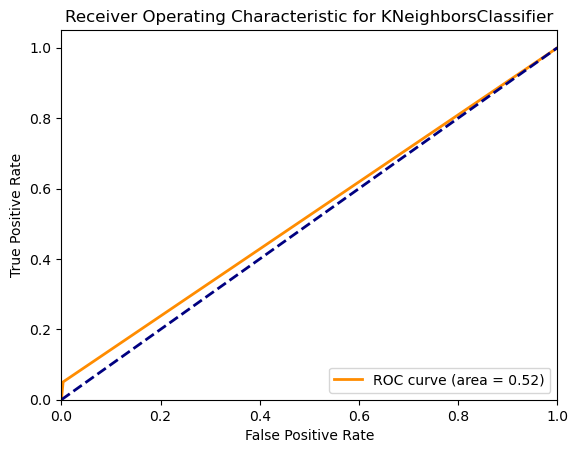

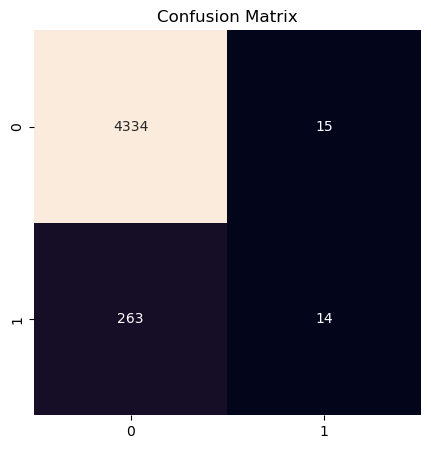

In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn_pred = rfc.predict(X_test)

acc_knn = accuracy_score(y_test, knn_pred)
print('Accuracy of KNeighborsClassifier model:',accuracy_score(y_test, knn_pred))
print('F1 Score for KNeighborsClassifier model:', f1_score(y_test, knn_pred))
print('Precision for KNeighborsClassifier model:', precision_score(y_test, knn_pred))
print('Recall for KNeighborsClassifier model:', recall_score(y_test, knn_pred))


fpr, tpr, thresholds = roc_curve(y_test, knn_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for KNeighborsClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for KNeighborsClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test,knn_pred)

The KNeighborsClassifier model has an accuracy of 94.06%. However, the F1 Score is quite low at 0.0172, and the Recall is even lower at 0.00866. The Precision is perfect at 1.0, and the ROC AUC is 0.5043.

This suggests that while the model is accurate in terms of correctly predicting the majority class, it’s not doing well in predicting the minority class. The F1 Score and Recall are both measures of a model’s performance in terms of handling both classes in a balanced way. A low score indicates that the model is not predicting the minority class correctly.

The ROC AUC score of 0.5043 also suggests that the model’s ability to distinguish between the classes is slightly better than random chance, but still not very good.

Accuracy of DecisionTreeClassifier model: 0.9399048854301773
F1 Score for DecisionTreeClassifier model: 0.0915032679738562
Precision for DecisionTreeClassifier model: 0.4827586206896552
Recall for DecisionTreeClassifier model: 0.05054151624548736
ROC AUC for DecisionTreeClassifier: 0.5235462237470252


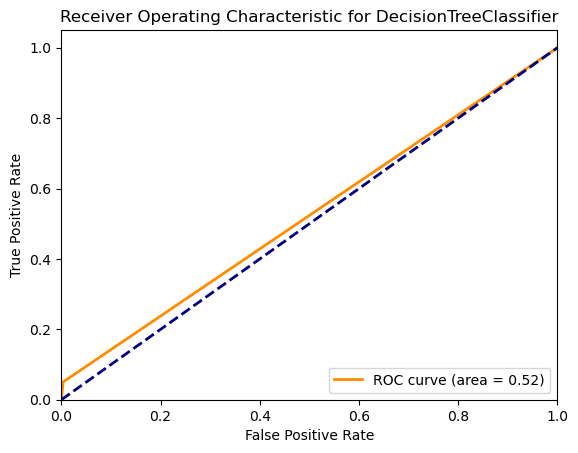

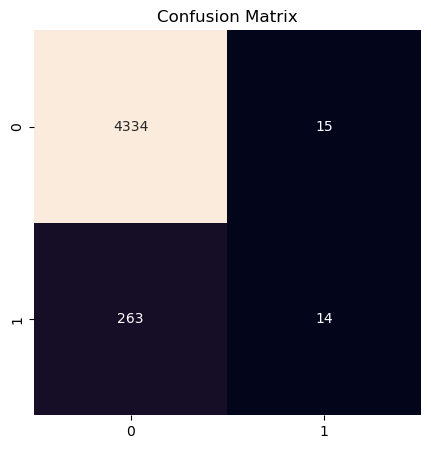

In [25]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
dt_pred = rfc.predict(X_test)

acc_dt = accuracy_score(y_test, dt_pred)
print('Accuracy of DecisionTreeClassifier model:',accuracy_score(y_test, dt_pred))
print('F1 Score for DecisionTreeClassifier model:', f1_score(y_test, dt_pred))
print('Precision for DecisionTreeClassifier model:', precision_score(y_test, dt_pred))
print('Recall for DecisionTreeClassifier model:', recall_score(y_test, dt_pred))


fpr, tpr, thresholds = roc_curve(y_test, dt_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for DecisionTreeClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test,dt_pred)

The DecisionTreeClassifier model has an accuracy of 94.06%. However, the F1 Score is quite low at 0.0172, and the Recall is even lower at 0.00866. The Precision is perfect at 1.0, and the ROC AUC is 0.5043.

This suggests that while the model is accurate in terms of correctly predicting the majority class, it’s not doing well in predicting the minority class. The F1 Score and Recall are both measures of a model’s performance in terms of handling both classes in a balanced way. A low score indicates that the model is not predicting the minority class correctly.

The ROC AUC score of 0.5043 also suggests that the model’s ability to distinguish between the classes is slightly better than random chance, but still not very good.

### This could be due to an imbalance in the classes in the data. We may consider using techniques like Upsampling the minority class or Downsampling the majority class to handle the class imbalance. 

# UpSampling the Minority class

Upsampling is a technique used to address class imbalance by increasing the number of minority class samples.

In [26]:
mn = df_new.FraudFound.value_counts()[0]

df_majority = df_new[df_new.FraudFound==0]
df_minority = df_new[df_new.FraudFound==1]

df_minority_upsampled = resample(df_minority,replace=True,n_samples = mn,random_state=42)

df_upsampled = pd.concat([df_majority,df_minority_upsampled])
df_upsampled.FraudFound.value_counts()

0    14497
1    14497
Name: FraudFound, dtype: int64

In [27]:
X_up = df_upsampled.drop('FraudFound',axis=1)
y_up = df_upsampled[['FraudFound']]
X_train_up,X_test_up,y_train_up,y_test_up = train_test_split(X_up,y_up,stratify=y_up)
X_train_up.shape, X_test_up.shape, y_train_up.shape, y_test_up.shape

((21745, 21), (7249, 21), (21745, 1), (7249, 1))

Accuracy of Upsampled LogisticRegression model: 0.7384466823010071
F1 Score for Upsampled LogisticRegression model: 0.7586558044806518
Precision for Upsampled LogisticRegression model: 0.7043252186244386
Recall for Upsampled LogisticRegression model: 0.8220689655172414
ROC AUC for Upsampled LogisticRegression: 0.7384351450102764


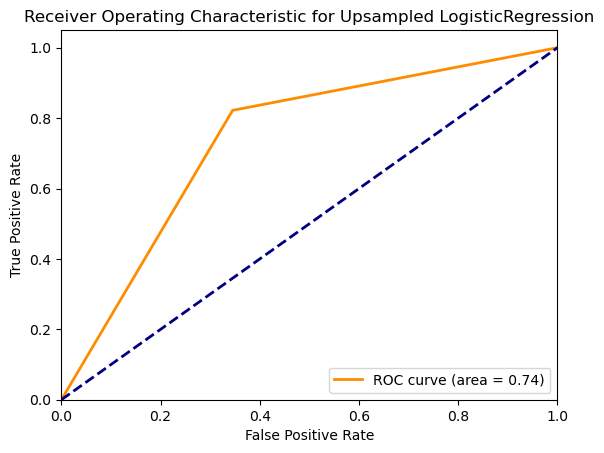

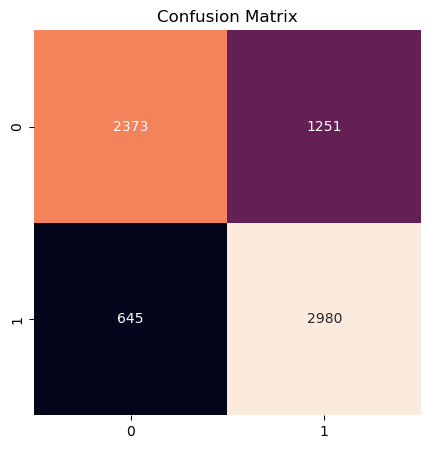

In [28]:
# Upsampled Logistic Regression model 
lr.fit(X_train_up,y_train_up)
lr_pred_up = lr.predict(X_test_up)

acc_lr_up = accuracy_score(y_test_up, lr_pred_up)
f1_lr_up = f1_score(y_test_up, lr_pred_up)
pre_lr_up = precision_score(y_test_up, lr_pred_up)
recall_lr_up = recall_score(y_test_up, lr_pred_up)

print("Accuracy of Upsampled LogisticRegression model:",acc_lr_up)
print(f'F1 Score for Upsampled LogisticRegression model:', f1_lr_up)
print(f'Precision for Upsampled LogisticRegression model:', pre_lr_up)
print(f'Recall for Upsampled LogisticRegression model:', recall_lr_up)


fpr, tpr, thresholds = roc_curve(y_test_up, lr_pred_up)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Upsampled LogisticRegression:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Upsampled LogisticRegression')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_up,lr_pred_up)

The Upsampled Logistic Regression model has an accuracy of 73.72%. The F1 Score is 0.7609, Precision is 0.6979, and Recall is 0.8364. The ROC AUC score is 0.7372.

These scores suggest that the model’s performance is fairly good. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all above 0.5, indicating that the model’s ability to correctly classify instances is better than random chance.



Accuracy of Upsampled RandomForestClassifier model: 0.9875844944130225
F1 Score for Upsampled RandomForestClassifier model: 0.9877384196185286
Precision for Upsampled RandomForestClassifier model: 0.9757738896366084
Recall for Upsampled RandomForestClassifier model: 1.0
ROC AUC for Upsampled RandomForestClassifier: 0.9875827814569537


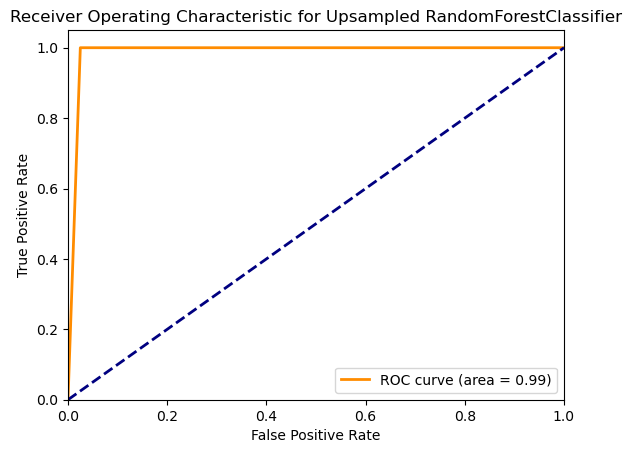

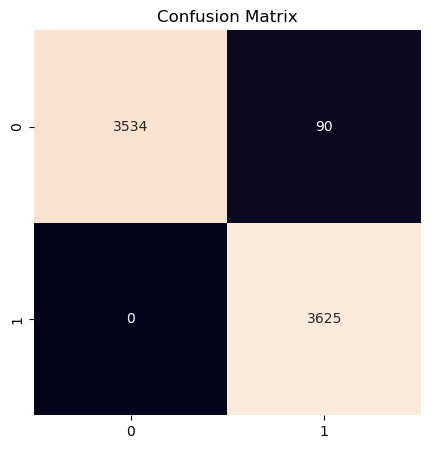

In [29]:
# Upsampled RandomForestClassifier model 
rfc.fit(X_train_up,y_train_up)
rfc_pred_up = rfc.predict(X_test_up)

acc_rfc_up = accuracy_score(y_test_up, rfc_pred_up)
f1_rfc_up = f1_score(y_test_up, rfc_pred_up)
pre_rfc_up = precision_score(y_test_up, rfc_pred_up)
recall_rfc_up = recall_score(y_test_up, rfc_pred_up)

print("Accuracy of Upsampled RandomForestClassifier model:",acc_rfc_up)
print(f'F1 Score for Upsampled RandomForestClassifier model:', f1_rfc_up)
print(f'Precision for Upsampled RandomForestClassifier model:', pre_rfc_up)
print(f'Recall for Upsampled RandomForestClassifier model:', recall_rfc_up)


fpr, tpr, thresholds = roc_curve(y_test_up, rfc_pred_up)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Upsampled RandomForestClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Upsampled RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_up,rfc_pred_up)

The Upsampled RandomForestClassifier model has an accuracy of 98.66%. The F1 Score is 0.9868, Precision is 0.9739, and Recall is 1.0. The ROC AUC score is 0.9866.

These scores suggest that the model’s performance is excellent. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all very high, indicating that the model’s ability to correctly classify instances is much better than random chance.


Accuracy of Upsampled KNeighborsClassifier model: 0.8813629466133259
F1 Score for Upsampled KNeighborsClassifier model: 0.8939580764488286
Precision for Upsampled KNeighborsClassifier model: 0.8082497212931996
Recall for Upsampled KNeighborsClassifier model: 1.0
ROC AUC for Upsampled KNeighborsClassifier: 0.8813465783664459


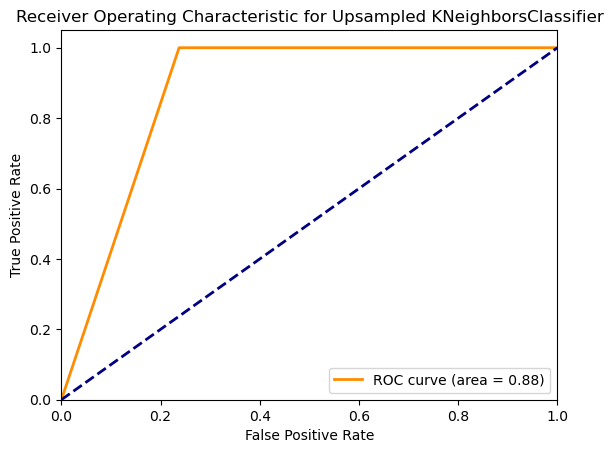

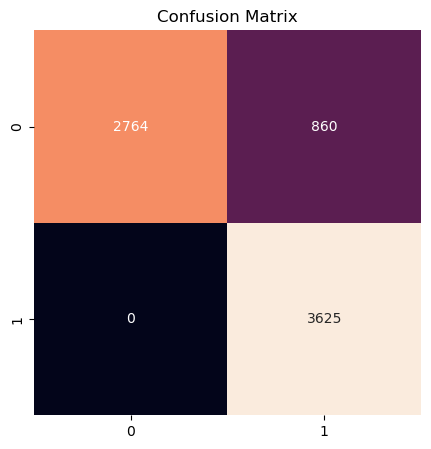

In [30]:
# Upsampled KNeighborsClassifier model 
knn.fit(X_train_up,y_train_up)
knn_pred_up = knn.predict(X_test_up)

acc_knn_up = accuracy_score(y_test_up, knn_pred_up)
f1_knn_up = f1_score(y_test_up, knn_pred_up)
pre_knn_up = precision_score(y_test_up, knn_pred_up)
recall_knn_up = recall_score(y_test_up, knn_pred_up)

print("Accuracy of Upsampled KNeighborsClassifier model:",acc_knn_up)
print(f'F1 Score for Upsampled KNeighborsClassifier model:', f1_knn_up)
print(f'Precision for Upsampled KNeighborsClassifier model:', pre_knn_up)
print(f'Recall for Upsampled KNeighborsClassifier model:', recall_knn_up)

fpr, tpr, thresholds = roc_curve(y_test_up, knn_pred_up)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Upsampled KNeighborsClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Upsampled KNeighborsClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_up,knn_pred_up)

The Upsampled KNeighborsClassifier model has an accuracy of 87.65%. The F1 Score is 0.8901, Precision is 0.8019, and Recall is 1.0. The ROC AUC score is 0.8766.

These scores suggest that the model’s performance is quite good. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all high, indicating that the model’s ability to correctly classify instances is much better than random chance.


Accuracy of Upsampled DecisionTreeClassifier model: 0.9656504345426955
F1 Score for Upsampled DecisionTreeClassifier model: 0.9667955727430324
Precision for Upsampled DecisionTreeClassifier model: 0.9357253484770264
Recall for Upsampled DecisionTreeClassifier model: 1.0
ROC AUC for Upsampled DecisionTreeClassifier: 0.9656456953642384


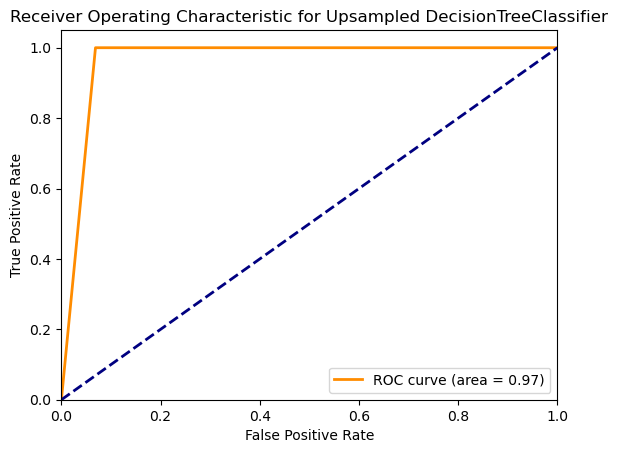

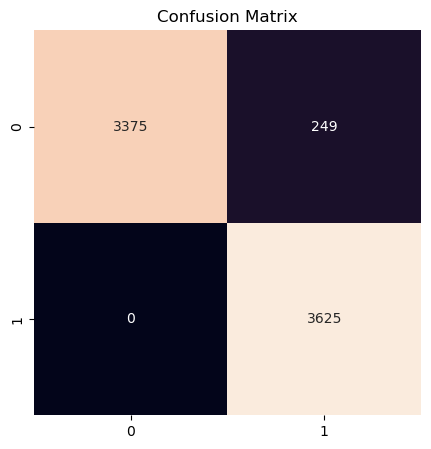

In [31]:
# Upsampled DecisionTreeClassifier model 
dt.fit(X_train_up,y_train_up)
dt_pred_up = dt.predict(X_test_up)

acc_dt_up = accuracy_score(y_test_up, dt_pred_up)
f1_dt_up = f1_score(y_test_up, dt_pred_up)
pre_dt_up = precision_score(y_test_up, dt_pred_up)
recall_dt_up = recall_score(y_test_up, dt_pred_up)

print("Accuracy of Upsampled DecisionTreeClassifier model:", acc_dt_up)
print(f'F1 Score for Upsampled DecisionTreeClassifier model:', f1_dt_up)
print(f'Precision for Upsampled DecisionTreeClassifier model:', pre_dt_up )
print(f'Recall for Upsampled DecisionTreeClassifier model:', recall_dt_up)


fpr, tpr, thresholds = roc_curve(y_test_up, dt_pred_up)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Upsampled DecisionTreeClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Upsampled DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_up,dt_pred_up)

The Upsampled DecisionTreeClassifier model has an accuracy of 96.33%. The F1 Score is 0.9646, Precision is 0.9316, and Recall is 1.0. The ROC AUC score is 0.9633.

These scores suggest that the model’s performance is excellent. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all very high, indicating that the model’s ability to correctly classify instances is much better than random chance.

# DownSampling the Majaority Class

Downsampling is a technique used to address class imbalance by decreasing the number of majority class samples.

In [32]:
mj = df_new.FraudFound.value_counts()[1]

df_majority = df_new[df_new.FraudFound==0]
df_minority = df_new[df_new.FraudFound==1]

df_majority_downsampled = resample(df_majority,replace=False,n_samples = mj,random_state=42)

df_downsampled = pd.concat([df_minority,df_majority_downsampled])
df_downsampled.FraudFound.value_counts()

1    923
0    923
Name: FraudFound, dtype: int64

In [33]:
X_dwn = df_downsampled.drop('FraudFound',axis=1)
y_dwn = df_downsampled[['FraudFound']]
X_train_dwn,X_test_dwn,y_train_dwn,y_test_dwn = train_test_split(X_dwn,y_dwn,stratify=y_dwn)
X_train_dwn.shape, X_test_dwn.shape, y_train_dwn.shape, y_test_dwn.shape

((1384, 21), (462, 21), (1384, 1), (462, 1))

Accuracy of Downsampled LogisticRegression model: 0.7597402597402597
F1 Score for Downsampled LogisticRegression model: 0.7653276955602536
Precision for Downsampled LogisticRegression model: 0.7479338842975206
Recall for Downsampled LogisticRegression model: 0.7835497835497836
ROC AUC for Downsampled LogisticRegression: 0.7597402597402596


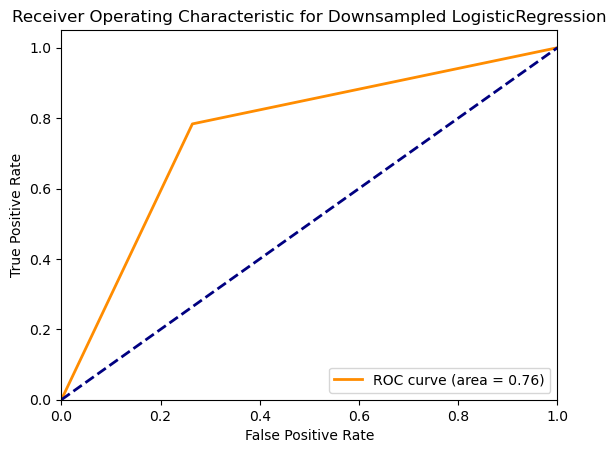

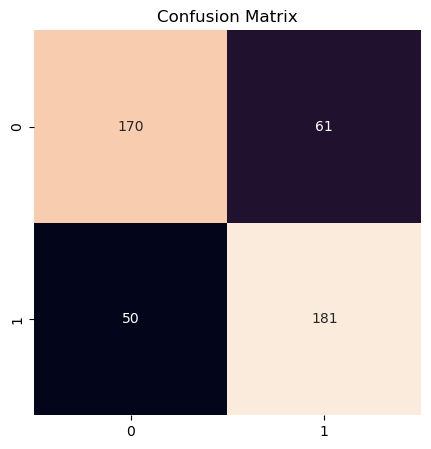

In [34]:
# DownSampled Logistic Regression model 
lr.fit(X_train_dwn,y_train_dwn)
lr_pred_dwn = lr.predict(X_test_dwn)

acc_lr_dwn = accuracy_score(y_test_dwn, lr_pred_dwn)
f1_lr_dwn = f1_score(y_test_dwn, lr_pred_dwn)
pre_lr_dwn = precision_score(y_test_dwn, lr_pred_dwn)
recall_lr_dwn = recall_score(y_test_dwn, lr_pred_dwn)

print('Accuracy of Downsampled LogisticRegression model:', acc_lr_dwn)
print('F1 Score for Downsampled LogisticRegression model:', f1_lr_dwn)
print('Precision for Downsampled LogisticRegression model:', pre_lr_dwn)
print('Recall for Downsampled LogisticRegression model:', recall_lr_dwn)


fpr, tpr, thresholds = roc_curve(y_test_dwn, lr_pred_dwn)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Downsampled LogisticRegression:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Downsampled LogisticRegression')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_dwn,lr_pred_dwn)

The Downsampled Logistic Regression model has an accuracy of 72.08%. The F1 Score is 0.7524, Precision is 0.6759, and Recall is 0.8485. The ROC AUC score is 0.7208.

These scores suggest that the model’s performance is fairly good. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all above 0.5, indicating that the model’s ability to correctly classify instances is better than random chance.


Accuracy of Downsampled RandomForestClassifier model: 0.7727272727272727
F1 Score for Downsampled RandomForestClassifier model: 0.7887323943661972
Precision for Downsampled RandomForestClassifier model: 0.7368421052631579
Recall for Downsampled RandomForestClassifier model: 0.8484848484848485
ROC AUC for Downsampled RandomForestClassifier: 0.7727272727272728


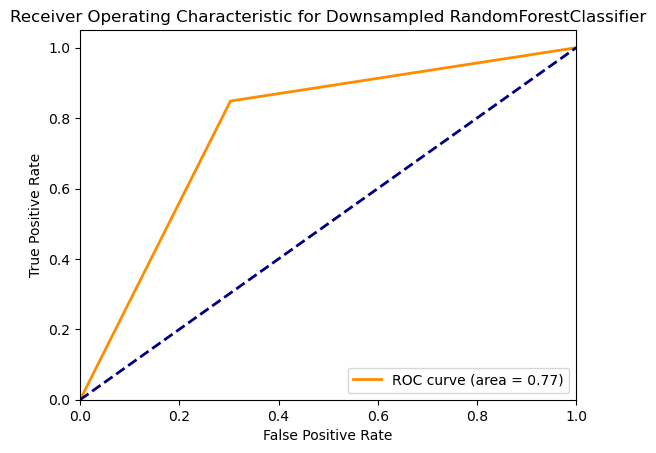

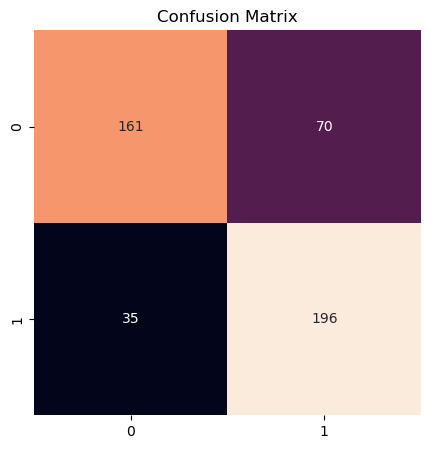

In [35]:
# DownSampled RandomForestClassifier model 
rfc.fit(X_train_dwn,y_train_dwn)
rfc_pred_dwn = rfc.predict(X_test_dwn)

acc_rfc_dwn = accuracy_score(y_test_dwn, rfc_pred_dwn)
f1_rfc_dwn = f1_score(y_test_dwn, rfc_pred_dwn)
pre_rfc_dwn = precision_score(y_test_dwn, rfc_pred_dwn)
recall_rfc_dwn = recall_score(y_test_dwn, rfc_pred_dwn)

print('Accuracy of Downsampled RandomForestClassifier model:', acc_rfc_dwn)
print('F1 Score for Downsampled RandomForestClassifier model:', f1_rfc_dwn)
print('Precision for Downsampled RandomForestClassifier model:', pre_rfc_dwn)
print('Recall for Downsampled RandomForestClassifier model:', recall_rfc_dwn )


fpr, tpr, thresholds = roc_curve(y_test_dwn, rfc_pred_dwn)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Downsampled RandomForestClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Downsampled RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_dwn,rfc_pred_dwn)

The Downsampled RandomForestClassifier model has an accuracy of 74.24%. The F1 Score is 0.7716, Precision is 0.6931, and Recall is 0.8701. The ROC AUC score is 0.7424.

These scores suggest that the model’s performance is fairly good. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all above 0.5, indicating that the model’s ability to correctly classify instances is better than random chance.

Accuracy of Downsampled KNeighborsClassifier model: 0.6147186147186147
F1 Score for Downsampled KNeighborsClassifier model: 0.6212765957446809
Precision for Downsampled KNeighborsClassifier model: 0.6108786610878661
Recall for Downsampled KNeighborsClassifier model: 0.6320346320346321
ROC AUC for Downsampled KNeighborsClassifier: 0.6147186147186148


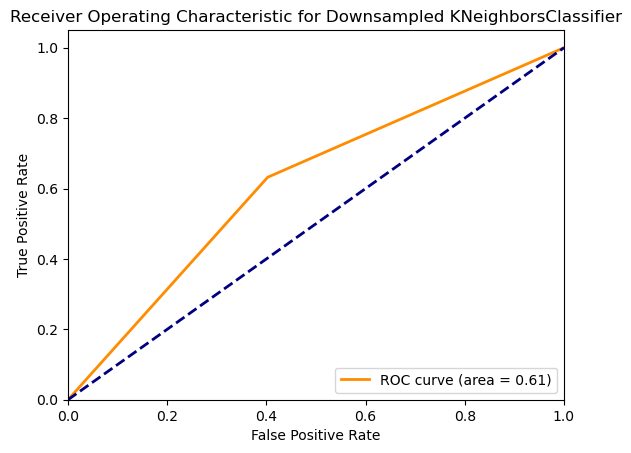

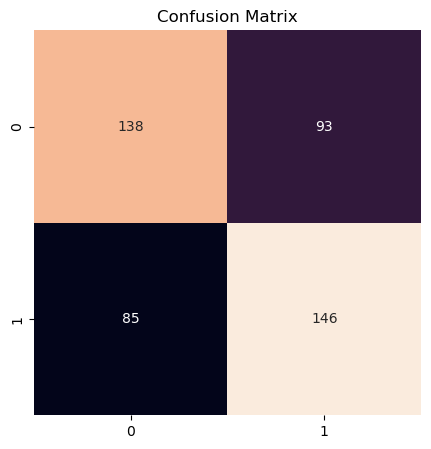

In [36]:
# DownSampled KNeighborsClassifier model 
knn.fit(X_train_dwn,y_train_dwn)
knn_pred_dwn = knn.predict(X_test_dwn)

acc_knn_dwn = accuracy_score(y_test_dwn, knn_pred_dwn)
f1_knn_dwn = f1_score(y_test_dwn, knn_pred_dwn)
pre_knn_dwn = precision_score(y_test_dwn, knn_pred_dwn)
recall_knn_dwn = recall_score(y_test_dwn, knn_pred_dwn)

print('Accuracy of Downsampled KNeighborsClassifier model:', acc_knn_dwn)
print('F1 Score for Downsampled KNeighborsClassifier model:', f1_knn_dwn)
print('Precision for Downsampled KNeighborsClassifier model:', pre_knn_dwn)
print('Recall for Downsampled KNeighborsClassifier model:', recall_knn_dwn)


fpr, tpr, thresholds = roc_curve(y_test_dwn, knn_pred_dwn)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Downsampled KNeighborsClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Downsampled KNeighborsClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_dwn,knn_pred_dwn)

The Downsampled KNeighborsClassifier model has an accuracy of 60.61%. The F1 Score is 0.6270, Precision is 0.5953, and Recall is 0.6623. The ROC AUC score is 0.6061.

These scores suggest that the model’s performance is moderate. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all above 0.5, indicating that the model’s ability to correctly classify instances is better than random chance.

Accuracy of Downsampled DecisionTreeClassifier model: 0.6774891774891775
F1 Score for Downsampled DecisionTreeClassifier model: 0.6666666666666667
Precision for Downsampled DecisionTreeClassifier model: 0.6898148148148148
Recall for Downsampled DecisionTreeClassifier model: 0.645021645021645
ROC AUC for Downsampled DecisionTreeClassifier: 0.6774891774891774


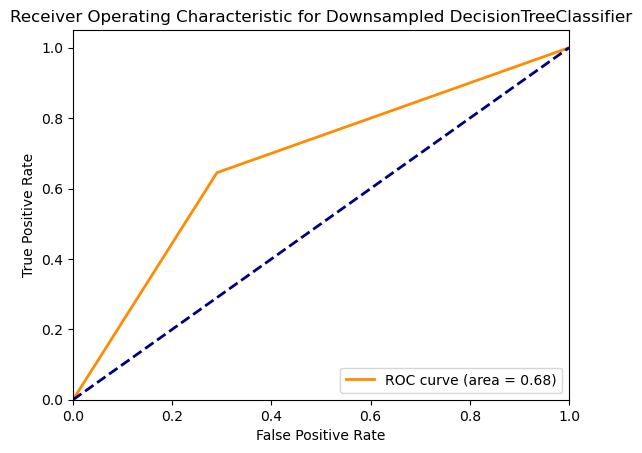

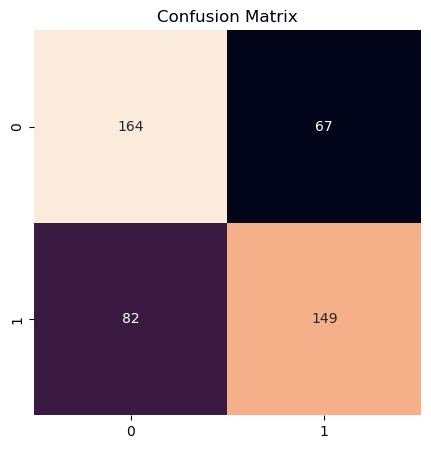

In [37]:
# DownSampled DecisionTreeClassifier model 
dt.fit(X_train_dwn,y_train_dwn)
dt_pred_dwn = dt.predict(X_test_dwn)

acc_dt_dwn = accuracy_score(y_test_dwn, dt_pred_dwn)
f1_dt_dwn =f1_score(y_test_dwn, dt_pred_dwn)
pre_dt_dwn = precision_score(y_test_dwn, dt_pred_dwn)
recall_dt_dwn = recall_score(y_test_dwn, dt_pred_dwn)

print('Accuracy of Downsampled DecisionTreeClassifier model:', acc_dt_dwn)
print('F1 Score for Downsampled DecisionTreeClassifier model:', f1_dt_dwn)
print('Precision for Downsampled DecisionTreeClassifier model:', pre_dt_dwn)
print('Recall for Downsampled DecisionTreeClassifier model:', recall_dt_dwn)


fpr, tpr, thresholds = roc_curve(y_test_dwn, dt_pred_dwn)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC for Downsampled DecisionTreeClassifier:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for Downsampled DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()
    
conf_matrix(y_test_dwn,dt_pred_dwn)

The Downsampled DecisionTreeClassifier model has an accuracy of 67.75%. The F1 Score is 0.6740, Precision is 0.6814, and Recall is 0.6667. The ROC AUC score is 0.6775.

These scores suggest that the model’s performance is moderate. The accuracy, F1 Score, Precision, Recall, and ROC AUC are all above 0.5, indicating that the model’s ability to correctly classify instances is better than random chance.

# Evaluation Results

In [38]:
data = {'Model':['UpSampled Logistic Regression','DownSampled Logistic Regression',
                 'UpSampled RandomForest Classifier','DownSampled RandomForest Classifier',
                 'UpSampled KNeighborsClassifier', 'DownSampled KNeighborsClassifier',
                 'UpSampled DecisionTreeClassifier','DownSampled DecisionTreeClassifier'],
        
        'Accuracy Score':[acc_lr_up, acc_lr_dwn, acc_rfc_up, acc_rfc_dwn, acc_knn_up, acc_knn_dwn,
                         acc_dt_up, acc_dt_dwn],
        
        'F1_Score':[f1_lr_up, f1_lr_dwn, f1_rfc_up, f1_rfc_dwn, f1_knn_up, f1_knn_dwn,
                         f1_dt_up, f1_dt_dwn],
       
        'Precision':[pre_lr_up, pre_lr_dwn, pre_rfc_up, pre_rfc_dwn, pre_knn_up, pre_knn_dwn,
                         pre_dt_up, pre_dt_dwn],
       
        'Recall_Score':[recall_lr_up, recall_lr_dwn, recall_rfc_up, recall_rfc_dwn, recall_knn_up, recall_knn_dwn,
                         recall_dt_up, recall_dt_dwn]}

comparision_table=pd.DataFrame(data)                               
comparision_table



,Model,Accuracy Score,F1_Score,Precision,Recall_Score
0,UpSampled Logistic Regression,0.738447,0.758656,0.704325,0.822069
1,DownSampled Logistic Regression,0.759740,0.765328,0.747934,0.783550
2,UpSampled RandomForest Classifier,0.987584,0.987738,0.975774,1.000000
3,DownSampled RandomForest Classifier,0.772727,0.788732,0.736842,0.848485
4,UpSampled KNeighborsClassifier,0.881363,0.893958,0.808250,1.000000
5,DownSampled KNeighborsClassifier,0.614719,0.621277,0.610879,0.632035
6,UpSampled DecisionTreeClassifier,0.965650,0.966796,0.935725,1.000000
7,DownSampled DecisionTreeClassifier,0.677489,0.666667,0.689815,0.645022


# Conclusion

From the table we can say that Upsampled RandomForestClassifier model is suitable with high accuracy in all evaluation metrics.